## Information/Vocabulary

``Bag of Words`` - Doesn't take into consideration the order of the words in the sentence, while ``Vector models`` and ``ML`` do.

``Scipy`` - Use instead of `numpy` when matrices are sparse.

``Tokens`` - Items used to represent a sentence: words, subwords, characters.

``Embeddings`` - Vector Representation of Tokens.

``Stemming`` - Chops off the end of the word (may not return a real word).

``Lemmatization`` - Returns the root of the word (**lemma**).

``TF - IDF(t, d)`` = `tf(t, d)` x `idf(t)`, where `t` is the term (token) and `d` is document. `tf(t, d)` is the count of term `t` on document `d` (or proportion if one normalizes it), while `idf(t)` = `log(N/N(t))`, where `N` is the number of documents (rows) and `N(t)` is how many of those documents contain term `t`.

If we are ranking scores based on a metric of vectors, it is a good idea to normalize the vectors so that **Euclidian Distance** and **Cosine Distance** give equivalent outputs.

`lil_matrix` and `csr_matrix` are two ways of storing non zero values for sparse matrices. The former is better for incremental construction (accessing random indeces) - although it needs more space - while the latter is better for bulk operations like normalization or matrix product.

`Word2Vec` is a **Neural Embedding**. It has two architectures:
- The `Skip Gram` is a Neural Network whose input is the one-hot representation of a word (which then gets mapped to a vector - **The embedding**) and its goal is to  predict words in the context window -> (x=central_word, y=context_word) for each context_word.
- The `Contiguous Bag of Words` (CBOW) is also a Neural network whose input is the context words and the objective is to predict the central word. In this case, the input vector is the mean of all the embeddings of the context_words -> (x=mean(context_words), y=central_word).

`GloVe` (Global Vectors for Word Representation) tries to obtain vector representations whose inner product (degree of similarity) is close to `log P(j | i)`, where `P(j | i)` (derived by the co-occurrence matrix) is the probability of word `j` appearing in the context of word `i`. In reality, the probability just becomes the co-occurence since the other term is absorved by the bias term.

Two types of Models in **NLP**:
- Discriminant Models: Directly learn `P(y | x)` (Neural Networks, Logistic Regression, ...)
- Generative Models: Learn `P(x | y)` and from there compute `P(y | x)` using Bayes Rule (Markov Models, ...)

## Code tips

``CountVectorizer`` is a package from ``scikit-learn`` for count embeddings (used mainly for documents):


 - ``CountVectorizer(stop_words="english"/list_predefined)`` - Remove **stop words** in english or from a predefined list. The default is None.

 - ``CountVectorizer(analyzer="word"/"char")`` - Defines the **tokenization** level. Either words or characters.

``nltk`` is a library for **NLP**:
- ``nltk.download('stopwords')`` to download the stopwords module.
- ``stopwords.words(language)`` to get the stopwords of the specific language. See all languages available in ``~/nltk_data/corpora/stopwords/``
- ``PorterStemmer()`` is used to get the Stem of a word.
- ``nltk.download("wordnet")`` to download the ``WordNetLemmatizer`` module, which is used to get the **lemma** of a word.

``Gensim`` is the library used for **Vector models**, namely `Word2vec` and `GloVe`. After having downloaded the table with the embeddings and unzipped it, we can do `word_vectors.most_similar(positive=[w1,...,wn], negative=[s1,...,sn])` to find the most similar word vector to the sum of the embeddings of the words in *positive* with the sum of the negative of the embeddings of the words in *negative*.

Using **NLTK**'s `TreeBankWordDeTokenizer` is the perfect way to build up the string after having tokenized it. It is specially useful when the tokenization takes into account punctuation, since joining words is different from joining word + punctuation.

If we are interested in computing the **ROC** and **AUC**, we need model probabilities. For that, we can u se the function ``model.predict_proba(X)`` from ``Scikit Learn``.

# Text Processing and Vector Models

## Stemming and Lemmatization

In [1]:
import nltk

In [ ]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

porter = PorterStemmer() 
lemmatizer = WordNetLemmatizer()

In [3]:
print(porter.stem("walking"))
print(porter.stem("walked"))
print(porter.stem("walks"))

walk
walk
walk


In [4]:
print(porter.stem("ran"))
print(porter.stem("run"))
print(porter.stem("running"))

ran
run
run


In [5]:
sentence = "Lemmatization is more sophisticated than stemming"
all_words = sentence.split()

for token in all_words:
    print(porter.stem(token))

lemmat
is
more
sophist
than
stem


In [6]:
print(lemmatizer.lemmatize("walking"))
print(lemmatizer.lemmatize("walking", pos=wordnet.VERB))
print()
print(lemmatizer.lemmatize("going"))
print(lemmatizer.lemmatize("going", pos=wordnet.VERB))

walking
walk

going
go


In [7]:
# Convert parts of speech tags to wordnet tags
def get_wordnet_pos(treebank_tag):
    match treebank_tag[0]:
        case 'J':
            return wordnet.ADJ
        case 'V':
            return wordnet.VERB
        case 'N':
            return wordnet.NOUN
        case 'R':
            return wordnet.ADV
        case _:
            return wordnet.NOUN

In [8]:
sentence = "Donald Trump has a devoted following"
list_words = sentence.split()

# Get the POS tags
words_and_tags = nltk.pos_tag(list_words)
words_and_tags

[('Donald', 'NNP'),
 ('Trump', 'NNP'),
 ('has', 'VBZ'),
 ('a', 'DT'),
 ('devoted', 'VBN'),
 ('following', 'NN')]

In [9]:
for word, tag in words_and_tags:
    lemma = lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag))
    print(lemma)

Donald
Trump
have
a
devote
following


## Count Vectorizer

In [10]:
import numpy as np
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

In [11]:
#for download in ["wordnet", "punkt", "averaged_perceptron_tagger"]:
    #nltk.download(download)

In [12]:
path_to_csv = "data/bbc_text_cls.csv"
df = pd.read_csv(path_to_csv)
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [13]:
inputs = df['text']
labels = df['labels']

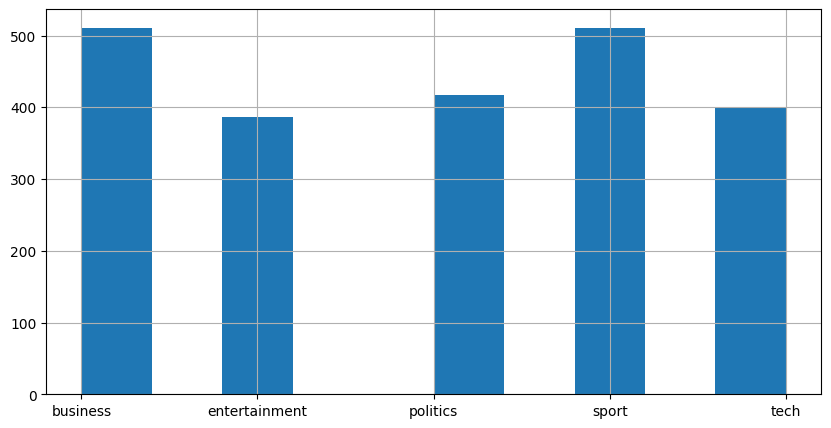

In [14]:
labels.hist(figsize=(10, 5));

In [15]:
# Define lemmatization tokenizer
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]
    
lemma_tokenizer = LemmaTokenizer()

In [16]:
# Define stem tokenizer
class StemTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
    
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.porter.stem(word) for word in tokens]
    
stem_tokenizer = StemTokenizer()

In [17]:
# Initialize Count
vectorizer = CountVectorizer()
vectorizer_stop_words = CountVectorizer(stop_words='english')
vectorizer_lemmatization = CountVectorizer(token_pattern=None, tokenizer=lemma_tokenizer)
vectorizer_stem = CountVectorizer(token_pattern=None, tokenizer=stem_tokenizer)

In [18]:
def process(inputs, labels, vectorizer):
    # Get the data
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=123)
    Xtrain = vectorizer.fit_transform(X_train) # It is now fitted on trainingg
    Xtest = vectorizer.transform(X_test)
    print(f"Number of rows: {Xtrain.shape[0]}")
    print(f"Number of words: {Xtrain.shape[1]}")
    print(f"Number of elements: {np.prod(Xtrain.shape)}")

    # Train model and check performance
    model = MultinomialNB()
    model.fit(Xtrain, y_train)
    print(f"Train score: {(model.score(Xtrain, y_train)*100):.2f}%")
    print(f"Test score:  {(model.score(Xtest, y_test)*100):.2f}%")
    
    return 

In [19]:
# Without removing stop words
print("Normal Vectorizer:\n")
process(inputs, labels, vectorizer)

# Removing stop words
print("\nRemoving Stop words\n")
process(inputs, labels, vectorizer_stop_words)

# Performing Lemmatization
print("\nPerforming Lemmatization\n")
process(inputs, labels, vectorizer_lemmatization)

# Performing Stemming
print("\nPerforming Stemming\n")
process(inputs, labels, vectorizer_stem)

Normal Vectorizer:

Number of rows: 1668
Number of words: 26287
Number of elements: 43846716
Train score: 99.22%
Test score:  97.13%

Removing Stop words

Number of rows: 1668
Number of words: 25995
Number of elements: 43359660
Train score: 99.28%
Test score:  97.67%

Performing Lemmatization

Number of rows: 1668
Number of words: 25894
Number of elements: 43191192
Train score: 99.22%
Test score:  96.77%

Performing Stemming

Number of rows: 1668
Number of words: 22714
Number of elements: 37886952
Train score: 98.92%
Test score:  96.95%


## TF-IDF (Term frequency - Inverse Document Frequency)

In [20]:
import ast
path_to_data = "data/tmdb_5000_movies.csv"
data = pd.read_csv(path_to_data)
data['keywords'] = data['keywords'].apply(ast.literal_eval)
data['genres'] = data['genres'].apply(ast.literal_eval)
data.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [21]:
def process_data(data):
    lista = []
    n = data.shape[0]
    keywords = data['keywords']
    genres = data['genres']
    for i in range(n):
        str1 = ', '.join([keywords[i][j]['name'].replace(" ", "") for j in range(len(keywords[i]))]) # Get the genres to just one token
        str2 = ', '.join([genres[i][j]['name'].replace(" ", "") for j in range(len(genres[i]))])
        lista.append(str1 + str2)

    return lista
    
new_data = process_data(data)

In [22]:
X = pd.DataFrame(data = {'name':data['original_title'], 'keywords':new_data})
X['name']

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4798                                 El Mariachi
4799                                   Newlyweds
4800                   Signed, Sealed, Delivered
4801                            Shanghai Calling
4802                           My Date with Drew
Name: name, Length: 4803, dtype: object

In [23]:
X['keywords']

0       cultureclash, future, spacewar, spacecolony, s...
1       ocean, drugabuse, exoticisland, eastindiatradi...
2       spy, basedonnovel, secretagent, sequel, mi6, b...
3       dccomics, crimefighter, terrorist, secretident...
4       basedonnovel, mars, medallion, spacetravel, pr...
                              ...                        
4798    unitedstates–mexicobarrier, legs, arms, paperk...
4799                                      Comedy, Romance
4800    date, loveatfirstsight, narration, investigati...
4801                                                     
4802    obsession, camcorder, crush, dreamgirlDocumentary
Name: keywords, Length: 4803, dtype: object

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

class MovieRecomendation():
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
        self.names_to_idx = {}
        self.names = []
        self.data = []

    def fit_transform(self, names, keywords):
        self.names_to_idx = {name: i for i, name in enumerate(names)}
        self.names = names
        self.data = self.vectorizer.fit_transform(keywords)
        return

    def recommend(self, target, top_k=5):
        try:
            idx = self.names_to_idx[target]
        except KeyError:
            raise ValueError(f"Index for '{target}' not found in names database")

        data = self.data
        movie = data[idx, :]
        normalized_data = normalize(data, axis=1)
        scores = np.dot(normalized_data, movie.T).toarray().ravel()
        scores[idx] = 0 # Mask the movie itself, doesn't make sense to recommend it (0 is the minimum for cosine similarity using TF-IDF since we're on the first quadrant)
        sorted_idx = np.argsort(scores)

        plt.plot(scores[sorted_idx[::-1]])

        print(f"Recommendations for the movie {target.upper()}:\n")
        for i in range(1, top_k+1):
            match i:
                case 1:
                    pos_arg = "st"
                case 2:
                    pos_arg = "nd"
                case 3:
                    pos_arg = "rd"
                case _:
                    pos_arg = "th"

            pos = f"{i} {pos_arg} Movie: \n"
            print(pos + names[sorted_idx[-i]])
            print()
        
        return 

names = X['name']
keywords = X['keywords']    
MovieRec = MovieRecomendation()
MovieRec.fit_transform(names, keywords)

Recommendations for the movie PIRATES OF THE CARIBBEAN: AT WORLD'S END:

1 st Movie: 
Pirates of the Caribbean: Dead Man's Chest

2 nd Movie: 
Pirates of the Caribbean: The Curse of the Black Pearl

3 rd Movie: 
Pirates of the Caribbean: On Stranger Tides

4 th Movie: 
La sirène du Mississipi

5 th Movie: 
The Brothers Grimm



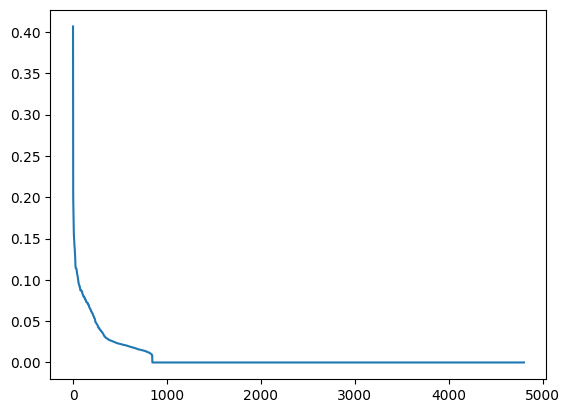

In [25]:
movie_to_recommend = "Pirates of the Caribbean: At World's End"
MovieRec.recommend(movie_to_recommend)

Recommendations for the movie SCREAM 3:

1 st Movie: 
Friday the 13th: A New Beginning

2 nd Movie: 
Friday the 13th Part VI: Jason Lives

3 rd Movie: 
Me, Myself & Irene

4 th Movie: 
Celebrity

5 th Movie: 
Friday the 13th Part VII: The New Blood



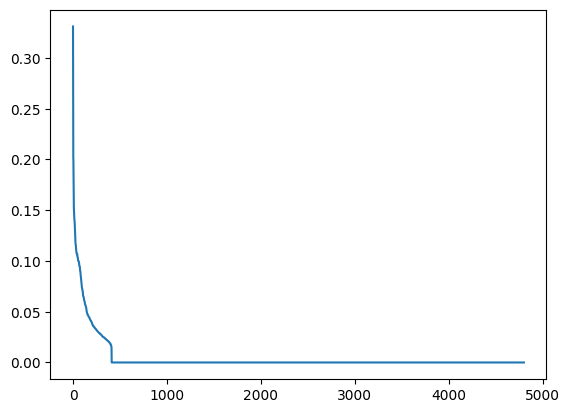

In [26]:
movie_to_recommend = "Scream 3"
MovieRec.recommend(movie_to_recommend)

Recommendations for the movie MORTAL KOMBAT:

1 st Movie: 
Mortal Kombat: Annihilation

2 nd Movie: 
DOA: Dead or Alive

3 rd Movie: 
Harry Potter and the Goblet of Fire

4 th Movie: 
Alone in the Dark

5 th Movie: 
The Angry Birds Movie



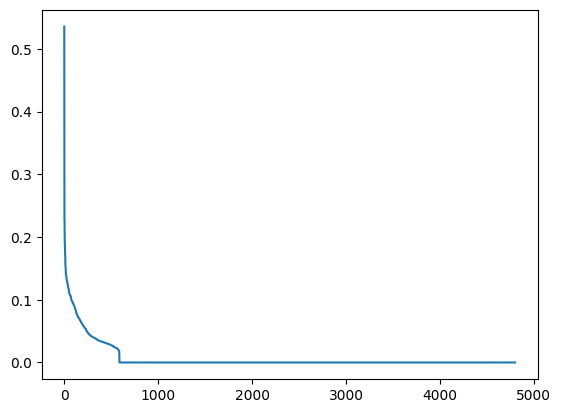

In [27]:
movie_to_recommend = "Mortal Kombat"
MovieRec.recommend(movie_to_recommend)

### `TF-IDF` from scratch using numpy!

In [28]:
import pandas as pd
path_to_data = "data/bbc_text_cls.csv"
df = pd.read_csv(path_to_data)
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [29]:
from nltk import word_tokenize
import numpy as np

class tfidf_vectorizer():
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idf = []
    
    def fit_transform(self, data):
        curr_idx = 0
        all_text = data['text']
        tokenized_docs = [] # Save computational time by storing the tokens in the first pass
        
        # Initialize the maping
        for text in all_text:
            all_tokens = word_tokenize(text.lower())
            doc_as_int = []
            for token in all_tokens:
                if token not in self.word2idx:
                    self.word2idx[token] = curr_idx
                    self.idx2word[curr_idx] = token
                    curr_idx += 1
                doc_as_int.append(self.word2idx[token])
            
            tokenized_docs.append(doc_as_int)

        N, V = len(all_text), len(self.word2idx.keys())
        arr = np.zeros(shape=(N, V))

        # TF
        for i, text in enumerate(tokenized_docs):
            for token_idx in tokenized_docs[i]:
                arr[i, token_idx] += 1

        # IDF (save it since the importance of the tokens should just be inferred from the training data)
        self.idf = np.log((N+1)/(np.sum(arr != 0, axis = 0) + 1)) + 1
        
        # Join everything
        arr *= self.idf
        
        return normalize(arr, axis=1)
    
    def transform(self, data):
        if isinstance(data, pd.DataFrame):
            all_text = data['text']
        else:
            all_text = data
        
        N, V = len(all_text), len(self.word2idx.keys())
        arr = np.zeros(shape=(N, V))

        # TF
        for i, text in enumerate(all_text):
            all_tokens = word_tokenize(text.lower())
            for token in all_tokens:
                if token in self.word2idx: # Ignore tokens not present in train data
                    arr[i, self.word2idx[token]] += 1
            
        # Join with IDF computed in fit
        arr *= self.idf
        
        return normalize(arr, axis=1)

In [30]:
tfidf = tfidf_vectorizer()
vectorizer = tfidf.fit_transform(df)
vectorizer.size

77013925

In [31]:
test_vec = tfidf.transform(df)
test_vec.size

77013925

### `TF-IDF` from scratch using scipy!

In [32]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
from sklearn.preprocessing import normalize
from scipy.sparse import lil_matrix, csr_matrix

class sparse_tfidf_vectorizer():
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idf = None
    
    def fit_transform(self, data):
        all_text = data['text']
        curr_idx = 0
        tokenized_docs = []
        
        # Build vocab and save tokenized docs
        for text in all_text:
            all_tokens = word_tokenize(text.lower())
            doc_as_int = []
            for token in all_tokens:
                if token not in self.word2idx:
                    self.word2idx[token] = curr_idx
                    self.idx2word[curr_idx] = token
                    curr_idx += 1
                doc_as_int.append(self.word2idx[token])
            tokenized_docs.append(doc_as_int)

        N, V = len(all_text), len(self.word2idx)
        arr = lil_matrix((N, V))  # lil is efficient for row updates

        # TF counts
        for i, doc in enumerate(tokenized_docs):
            for idx in doc:
                arr[i, idx] += 1

        # Compute IDF
        df = np.array((arr > 0).sum(axis=0)).flatten()
        self.idf = np.log((N + 1) / (df + 1)) + 1

        # Apply IDF
        arr = arr.tocsr()
        arr = arr.multiply(self.idf)
        
        return normalize(arr, axis=1)

    
    def transform(self, data):
        if isinstance(data, pd.DataFrame):
            all_text = data['text']
        else:
            all_text = data
        
        N, V = len(all_text), len(self.word2idx.keys())
        arr = lil_matrix((N, V))

        # TF
        for i, text in enumerate(all_text):
            all_tokens = word_tokenize(text.lower())
            for token in all_tokens:
                if token in self.word2idx: # Ignore tokens not present in train data
                    arr[i, self.word2idx[token]] += 1
            
        # Apply IDF
        arr = arr.tocsr()
        arr = arr.multiply(self.idf)
        
        return normalize(arr, axis=1)

In [33]:
tfidf = sparse_tfidf_vectorizer()
vectorizer2 = tfidf.fit_transform(df)
vectorizer2

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 469214 stored elements and shape (2225, 34613)>

In [34]:
test_vec2 = tfidf.transform(df)
test_vec2

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 469214 stored elements and shape (2225, 34613)>

## Vector models 

In this case I can't write code since it is not compatible with **Python 3.13.x** (**GloVe** and **Word2Vec**). 

# Markov Models

## Markov Text Classifier 

In [35]:
import string

poe_path = "data/poe.txt"
frost_path = "data/frost.txt"
mapa_str_idx = {'Poe': 0, 'Frost': 1}

lista = []

def process_file(path, label):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip().lower()
            
            if line:
                line = line.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
                lista.append([line, label])

# Populate with Poe
process_file(poe_path, mapa_str_idx['Poe'])

# Populate with Frost
process_file(frost_path, mapa_str_idx['Frost'])

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.preprocessing import normalize

data = pd.DataFrame(lista, columns=['text', 'label'])
data.head()

# Get X and y
X, y = data['text'], data['label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [37]:
class Markov():
    def __init__(self, mapa):
        self.mapa = mapa
        self.word2idx_poe = {}
        self.word2idx_frost = {}
        self.poe_prob = 0
        self.matrix_poe = np.array([])
        self.matrix_frost = np.array([])
        self.pi0_poe = np.array([])
        self.pi0_frost = np.array([])

    def fit(self, X, y):
        N = len(y)
        curr_idx_poe = 0
        curr_idx_frost = 0
        num_poe = 0
        num_frost = 0
        lista_idx_poe = []
        lista_idx_frost = []

        for text, label in zip(X, y):
            curr_lista = []
            words = word_tokenize(text)
            
            # Process Poe
            if self.mapa['Poe'] == label:
                num_poe += 1
                for token in words:
                    if token not in self.word2idx_poe:
                        self.word2idx_poe[token] = curr_idx_poe
                        curr_idx_poe += 1
                    
                    curr_lista.append(self.word2idx_poe[token])

                lista_idx_poe.append(curr_lista)

            # Process Frost
            else:
                num_frost += 1
                for token in words:
                    if token not in self.word2idx_frost:
                        self.word2idx_frost[token] = curr_idx_frost
                        curr_idx_frost += 1 
                    
                    curr_lista.append(self.word2idx_frost[token])

                lista_idx_frost.append(curr_lista)
            
        
        self.poe_prob = np.log(float(num_poe) / N)
        self.frost_prob = np.log(float(num_frost) / N)

        V_poe, V_frost = len(self.word2idx_poe.values()) + 1, len(self.word2idx_frost.values()) + 1 # To account for unknown words
        self.word2idx_frost['<unk>'] = V_frost - 1 # Map unknown words to last indice
        self.word2idx_poe['<unk>'] = V_poe - 1
        
        matrix_poe, matrix_frost = np.ones(shape=(V_poe, V_poe)), np.ones(shape=(V_frost, V_frost))
        pi0_poe, pi0_frost = np.ones(shape=(V_poe, 1)), np.ones(shape=(V_frost, 1))

        # Populate poe
        for doc in lista_idx_poe:
            for i, idx in enumerate(doc):
                if i == 0:
                    pi0_poe[idx] += 1
                else:
                    idx2 = doc[i-1]
                    matrix_poe[idx2, idx] += 1
        
        # Populate frost
        for doc in lista_idx_frost:
            for i, idx in enumerate(doc):
                if i == 0:
                    pi0_frost[idx] += 1
                else:
                    idx2 = doc[i-1]
                    matrix_frost[idx2, idx] += 1

        # Normalize counts to probabilities then to log
        self.matrix_poe, self.matrix_frost = np.log(normalize(matrix_poe, axis=1, norm='l1')), np.log(normalize(matrix_frost, axis=1, norm='l1'))
        self.pi0_poe, self.pi0_frost = np.log(normalize(pi0_poe, norm='l1')), np.log(normalize(pi0_frost, norm='l1'))
    
    def predict(self, X):
        size = len(X)
        yhat = np.zeros(shape=(size))

        for j, doc in enumerate(X):
            words = word_tokenize(doc)
            prob_poe = 0
            prob_frost = 0

            for i, token in enumerate(words):
                token_poe, token_frost = token, token
                if token_poe not in self.word2idx_poe:
                    token_poe = '<unk>'
                if token_frost not in self.word2idx_frost:
                    token_frost = '<unk>'

                idx_poe = self.word2idx_poe[token_poe] 
                idx_frost = self.word2idx_frost[token_frost] 
                if i == 0:
                    prob_poe += self.pi0_poe[idx_poe]
                    prob_frost += self.pi0_frost[idx_frost]
                else:
                    prev_token_poe, prev_token_frost = words[i-1], words[i-1]
                    if prev_token_poe not in self.word2idx_poe:
                        prev_token_poe = '<unk>'
                    if  prev_token_frost not in self.word2idx_frost:
                        prev_token_frost = '<unk>'

                    last_idx_poe = self.word2idx_poe[prev_token_poe]
                    last_idx_frost = self.word2idx_frost[prev_token_frost] 
                    
                    prob_poe += self.matrix_poe[last_idx_poe, idx_poe]
                    prob_frost += self.matrix_frost[last_idx_frost, idx_frost]
        
            final_poe_prob = prob_poe + self.poe_prob
            final_frost_prob = prob_frost + self.frost_prob

            yhat[j] = self.mapa['Poe'] if final_poe_prob > final_frost_prob else self.mapa['Frost']
        
        return yhat

def accuracy(yhat, y):
    return np.mean(yhat == y)
    
def confusion_matrix(yhat, y, labels):
    conf_matrix = np.zeros(shape=(2, 2), dtype=int)
    for pred, true in zip(yhat, y):
        conf_matrix[int(true), int(pred)] += 1
    
    df = pd.DataFrame(conf_matrix, index=[f"True {l}" for l in labels],
                                   columns=[f"Pred {l}" for l in labels])
   

    return conf_matrix, df

def f1_score(confusion_matrix):
    eps = 1e-6
    precision = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[0][1] + eps)
    recall = confusion_matrix[1][1] / (confusion_matrix[1][1] + confusion_matrix[1][0] + eps)
    f1 = (2 * precision * recall) / (precision + recall + eps)

    return precision, recall, f1

In [38]:
labels = ['Poe', 'Frost']

# Initialize and fit model
markov = Markov(mapa_str_idx)
markov.fit(X_train, y_train)
print("Info:")
print(f"Probability of Poe Poem: {np.exp(markov.poe_prob):.2f}")
print(f"Probability of Frost Poem: {np.exp(markov.frost_prob):.2f}")

# Get Train performance
y_hat = markov.predict(X_train)
acc = accuracy(y_hat, y_train)
conf, df = confusion_matrix(y_hat, y_train, labels)
prec, rec, f1 = f1_score(conf)

print(f"\nTrain Metrics:")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Precision: {prec * 100:.2f}%")
print(f"Recall: {rec * 100:.2f}%")
print(f"F1-score: {f1:.3f}")
print(df)

# Get Test performance
y_hat = markov.predict(X_test)
acc = accuracy(y_hat, y_test)
conf, df = confusion_matrix(y_hat, y_test, labels)
prec, rec, f1 = f1_score(conf)

print(f"\nTest Metrics:")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Precision: {prec * 100:.2f}%")
print(f"Recall: {rec * 100:.2f}%")
print(f"F1-score: {f1:.3f}")
print(df)

Info:
Probability of Poe Poem: 0.33
Probability of Frost Poem: 0.67

Train Metrics:
Accuracy: 99.20%
Precision: 99.80%
Recall: 99.01%
F1-score: 0.994
            Pred Poe  Pred Frost
True Poe         496           2
True Frost        10         999

Test Metrics:
Accuracy: 47.76%
Precision: 97.85%
Recall: 21.31%
F1-score: 0.350
            Pred Poe  Pred Frost
True Poe         218           2
True Frost       336          91


## Markov Text Generator 

In [7]:
import string

data_path = "data/robert.txt"

def process_file(path):
    poems = []
    curr_poem = []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip().lower()
            
            if line:
                line = line.translate(str.maketrans('', '', string.punctuation))
                curr_poem.append(line)
            else:
        
                if curr_poem:
                    poems.append(" <new_line> ".join(curr_poem))  # join lines into one string
                    curr_poem = []

        if curr_poem:
            poems.append(" <new_line> ".join(curr_poem))

    return poems

# Populate with the data
X = process_file(data_path)

In [8]:
import numpy as np

class MarkovGenerator():
    def __init__(self):
        self.bi_probs = {}
        self.uni_probs = {}
        self.pi0 = {}
        
    def fit(self, X):
        for poem in X:
            last_token, last_two_token = None, None
            all_words = poem.split() + ['<eos>'] # Add end of speech token to train
            for token in all_words:
                # First word
                if not last_token:
                    if token not in self.pi0:
                        self.pi0[token] = 1
                    else:
                        self.pi0[token] += 1
                
                # Second word
                elif not last_two_token:
                    if last_token not in self.uni_probs:
                        self.uni_probs[last_token] = {token: 1}
                    
                    elif token not in self.uni_probs[last_token]:
                        self.uni_probs[last_token][token] = 1
                    
                    else:
                        self.uni_probs[last_token][token] += 1
                
                # Rest of the words
                else:
                    if last_two_token not in self.bi_probs:
                        self.bi_probs[last_two_token] = {last_token: {token: 1}}

                    elif last_token not in self.bi_probs[last_two_token]:
                        self.bi_probs[last_two_token][last_token] =  {token: 1}

                    elif token not in self.bi_probs[last_two_token][last_token]:
                        self.bi_probs[last_two_token][last_token][token] = 1
                    
                    else:
                        self.bi_probs[last_two_token][last_token][token] += 1


                last_token, last_two_token = token, last_token
    
        # Normalize the probabilities
        total_count = float(sum(self.pi0.values()))
        for word in self.pi0.keys():
            self.pi0[word] /= total_count
        
        for prev_word in self.uni_probs.keys():
            total_count = float(sum(self.uni_probs[prev_word].values()))
            for word in self.uni_probs[prev_word].keys():
                self.uni_probs[prev_word][word] /= total_count
        
        for last_two_word in self.bi_probs.keys():
            for prev_word in self.bi_probs[last_two_word].keys():
                total_count = float(sum(self.bi_probs[last_two_word][prev_word].values()))
                for word in self.bi_probs[last_two_word][prev_word].keys():
                    self.bi_probs[last_two_word][prev_word][word] /= total_count
        
    def generate(self, num_token=100):
        all_text = []
        last_two_word, last_word = None, None
        for _ in range(num_token):
            if not last_word:
                words, probs = list(self.pi0.keys()), list(self.pi0.values())

            elif not last_two_word:
                if last_word in self.uni_probs:
                    words, probs = list(self.uni_probs[last_word].keys()), list(self.uni_probs[last_word].values())
                else:
                    words, probs = list(self.pi0.keys()), list(self.pi0.values())

            else:
                if last_two_word in self.bi_probs and last_word in self.bi_probs[last_two_word]:
                    words, probs = list(self.bi_probs[last_two_word][last_word].keys()), \
                                list(self.bi_probs[last_two_word][last_word].values())
                
                elif last_word in self.uni_probs:
                    words, probs = list(self.uni_probs[last_word].keys()), list(self.uni_probs[last_word].values())
                
                else:
                    words, probs = list(self.pi0.keys()), list(self.pi0.values())

            gen_word = np.random.choice(words, p=probs)
            if gen_word == '<eos>': # Check if end of speech token is selected
                break
                    
            all_text.append(gen_word)
            last_two_word, last_word = last_word, gen_word

        return ' '.join(all_text).replace(" <new_line> ", "\n").capitalize()

In [9]:
gen = MarkovGenerator()
gen.fit(X)

In [16]:
print(gen.generate())

My little horse must think it isnt worth the mortgage
i hope if he must have heard of clara robinson
the mica sheets were big as plateglass windows
hed like to hear the voices seem to you to cool the room
with me
you couldnt call it living for it aint
there is a good deal to bad masonry
you riddle with your genealogy
like graveyard marble sculpture in the cellar in spring
struck the hand off brittle on the mountain halfway up
in front of twenty then
having


## Cipher Decryption

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import random
import re
import requests
import os
import textwrap

# Get the .txt file
if not os.path.exists(os.path.join("data", 'moby_dick.txt')):
  print("Downloading moby dick...")
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt', 'w', encoding='utf-8') as f:
    f.write(r.content.decode())

In [2]:
class LM():
    def __init__(self):
        self.mat = np.ones(shape=(26, 26))
        self.pi0 = np.ones(shape=(26))

    def fit(self, X):
        regex = re.compile('[^a-zA-Z]')
        # Populate matrix and vector
        with open(X, 'r', encoding='utf-8') as f:
            for line in f:
                if line:
                    line = line.translate(str.maketrans('', '', string.punctuation))
                    line = regex.sub(' ', line)
                    tokens = line.lower().split()
                    for token in tokens:
                        prev_idx = ord(token[0]) - ord('a')
                        self.pi0[prev_idx] += 1
                        for char in token[1:]:
                            curr_idx = ord(char) - ord('a')
                            self.mat[prev_idx, curr_idx] += 1
                            prev_idx = curr_idx
        
        # Normalize matrix and vector
        self.pi0 /= self.pi0.sum()
        self.pi0 = np.log(self.pi0)

        counts = np.sum(self.mat, axis=1)
        self.mat /= counts
        self.mat = np.log(self.mat)
    
    def predict(self, message):
        tokens = message.lower().split()
        total_prob = 0

        for token in tokens:
            prev_idx = ord(token[0]) - ord('a')
            total_prob += self.pi0[prev_idx]
            for char in token[1:]:
                curr_idx = ord(char) - ord('a')
                total_prob += self.mat[prev_idx, curr_idx]
                prev_idx = curr_idx
        
        return total_prob

class Population():
    def __init__(self, num_parents=5, num_child = 3):
        self.num_parents = num_parents
        self.num_child = num_child
    
    def populate(self):
        population = []
        for _ in range(self.num_parents):
            new_population = Being()
            population.append(new_population)
        
        self.population = population

    def Evolve(self, lang_model, message, num_epochs=100):
        for _ in range(num_epochs):
            new_lista = []
            for parent in self.population:
                new_lista.append(parent)
                children = parent.get_off_spring()
                new_lista.extend(children)
            
            scores = np.zeros(shape=(len(new_lista)))
            for i, being in enumerate(new_lista):
                decoded_msg = being.decode(message)
                scores[i] = -lang_model.predict(decoded_msg)
            
            indices = np.argsort(scores)
            self.population = [new_lista[idx] for idx in indices[:self.num_parents]]
        
    def getMessage(self, orig_msg):
        best_being = self.population[0]
        message = best_being.decode(orig_msg)
        print("Recovered Message:")
        print(textwrap.fill(message))

class Being(Population):
    def __init__(self, arr=np.array([])):
        super().__init__() # Get some parameters
        if len(arr) == 0:
            chars = list(string.ascii_lowercase)
            arr = np.array(chars)
            np.random.shuffle(arr)
        
        self.mapa = arr
    
    def get_off_spring(self):
        children = []
        for _ in range(self.num_child):
            idx, idx2 = np.random.randint(26, size=2)
            new_mapa = self.get_map().copy()
            new_mapa[idx], new_mapa[idx2] = new_mapa[idx2], new_mapa[idx]
            new_being = Being(new_mapa)
            children.append(new_being)
        
        return children
    
    def get_map(self):
        return self.mapa
    
    def decode(self, message):
        char_list = []
        words = message.lower().split()
        for i, word in enumerate(words):
            for char in word:
                idx = ord(char) - ord('a')
                char_list.append(self.mapa[idx])
            
            if i < len(words) - 1:
                char_list.append(" ")
        
        return ''.join(char_list)

In [ ]:
original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''
print("Original Message:")
print(textwrap.fill(original_message))

def encrypt(message, mapa):
    message = message.translate(str.maketrans('', '', string.punctuation))
    char_list = []
    words = message.lower().split()
    for i, word in enumerate(words):
        for char in word:
            idx = ord(char) - ord('a')
            char_list.append(mapa[idx])
            
        if i < len(words) - 1:
            char_list.append(" ")
        
    return ''.join(char_list)


chars = list(string.ascii_lowercase)
encrypt_map = np.array(chars)
np.random.shuffle(encrypt_map) 

new_message = encrypt(original_message, encrypt_map)
print("\nEncrypted Message:")
print(textwrap.fill(new_message))

Original Message:
I then lounged down the street and found, as I expected, that there
was a mews in a lane which runs down by one wall of the garden. I lent
the ostlers a hand in rubbing down their horses, and received in
exchange twopence, a glass of half-and-half, two fills of shag
tobacco, and as much information as I could desire about Miss Adler,
to say nothing of half a dozen other people in the neighbourhood in
whom I was not in the least interested, but whose biographies I was
compelled to listen to.

Encrypted Message:
l dasp ecophsi iczp das mdwssd vpi jcopi vm l srnsqdsi davd dasws zvm
v xszm lp v evps zalqa wopm iczp bu cps zvee cj das hvwisp l espd das
cmdeswm v avpi lp wobblph iczp daslw acwmsm vpi wsqslysi lp srqavphs
dzcnspqs v hevmm cj avejvpiavej dzc jleem cj mavh dcbvqqc vpi vm xoqa
lpjcwxvdlcp vm l qcoei ismlws vbcod xlmm viesw dc mvu pcdalph cj avej
v ictsp cdasw nscnes lp das pslhabcowacci lp zacx l zvm pcd lp das
esvmd lpdswsmdsi bod zacms blchwvnalsm l zvm qcxns

In [6]:
X = "data/moby_dick.txt"

# Get the language model
llm = LM()
llm.fit(X)

# Get the population
pop = Population()
pop.populate()
pop.Evolve(llm, new_message, num_epochs=10000)

# Get the message
pop.getMessage(new_message)

Recovered Message:
i then lounged down the street and yound as i expected that there was
a mews in a lane which runs down fz one wall oy the garden i lent the
ostlers a hand in ruffing down their horses and received in exchange
twopence a glass oy halyandhaly two yills oy shag tofacco and as much
inyormation as i could desire afout miss adler to saz nothing oy haly
a doken other people in the neighfourhood in whom i was not in the
least interested fut whose fiographies i was compelled to listen to


# Machine Learning

## Spam Detection 

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sn
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.corpus import wordnet

In [75]:
# Convert parts of speech tags to wordnet tags
def get_wordnet_pos(treebank_tag):
    match treebank_tag[0]:
        case 'J':
            return wordnet.ADJ
        case 'V':
            return wordnet.VERB
        case 'N':
            return wordnet.NOUN
        case 'R':
            return wordnet.ADV
        case _:
            return wordnet.NOUN

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]

In [86]:
path_to_data = "data/spam.csv"
df = pd.read_csv(path_to_data, encoding='ISO-8859-1')
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ["labels", "data"]
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


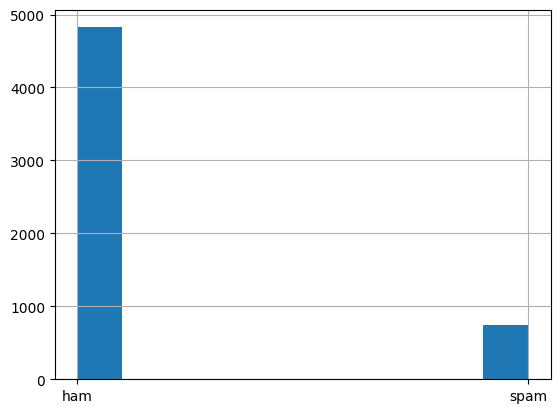

In [90]:
df["labels"].hist();

In [88]:
mapa = {'ham': 0, 'spam':1}
X, y = df['data'], df['labels']
y_processed = np.array([mapa[elem] for elem in y])
X_train, X_test, y_train, y_test = train_test_split(X, y_processed, test_size=0.3)

In [100]:
class Model:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model

    def fit(self, X, y):
        new_X = self.vectorizer.fit_transform(X)
        self.model.fit(new_X, y)
    
    def predict(self, X):
        new_X = self.vectorizer.transform(X)
        return self.model.predict(new_X)    

    def get_probabilities(self, X):
        if hasattr(self.model, "predict_proba"):
            new_X = self.vectorizer.transform(X)
            return self.model.predict_proba(new_X)
        else:
            raise ValueError("Model doesn't output probabilities!")
    
    def get_metrics(self, X, y):
        y_hat = self.predict(X)
        y_probs = self.get_probabilities(X)
        acc = np.mean(y_hat == y)
        roc = roc_auc_score(y, y_probs[:, 1])  
        f1 = f1_score(y_true=y, y_pred=y_hat)
        cf = confusion_matrix(y_true=y, y_pred=y_hat)
        classes = ['ham', 'spam']
        df = pd.DataFrame(cf, index=classes, columns=classes)
        print("Metrics for the classification:\n")
        print(f"Accuracy: {(acc * 100):.2f}%")
        print(f"AUC score: {roc:.2f}")
        print(f"F1 score: {f1:.2f}")
        print(f"Confusion Matrix: ")
        
        plt.figure(figsize=(5,4))
        sn.heatmap(df, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

        return


# lemma_tokenizer = LemmaTokenizer() -> Worse Metrics
count_tokenizer = CountVectorizer(stop_words='english')
model = MultinomialNB()
classifier = Model(count_tokenizer, model)

Metrics for the classification:

Accuracy: 99.46%
AUC score: 1.00
F1 score: 0.98
Confusion Matrix: 


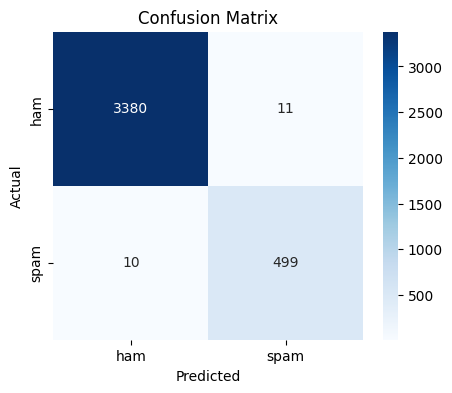

In [101]:
classifier.fit(X_train, y_train)
classifier.get_metrics(X_train, y_train)

Metrics for the classification:

Accuracy: 98.56%
AUC score: 0.99
F1 score: 0.95
Confusion Matrix: 


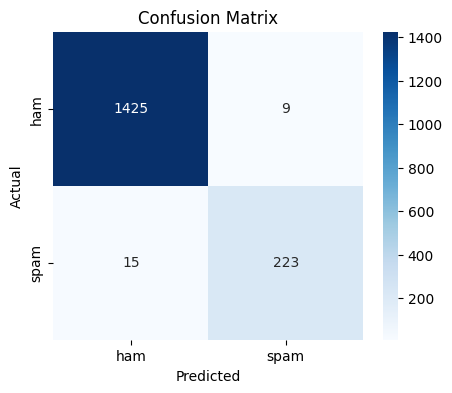

In [94]:
classifier.get_metrics(X_test, y_test)